In [1]:
%matplotlib inline
import datetime as dt
import gc
import multiprocessing as mul
from multiprocessing.dummy import Pool as TPool
import os

import cache_magic
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import modin.pandas as pd
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from IPython.core.interactiveshell import InteractiveShell

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, auc

import dankypipe.pipe as pipe
from dankypipe.utils import *

InteractiveShell.ast_node_interactivity = 'all'

### Data load

In [2]:
dtypes = DTypes({
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion_float':                                  'float16',
        'AppVersion_float':                                     'float16',
        'AvSigVersion_float':                                   'float16',
        'IsBeta':                                               'int8',
        'RtpStateBitfield_1':                                   'int8',
        'RtpStateBitfield_2':                                   'int8',
        'RtpStateBitfield_3':                                   'int8',
        'RtpStateBitfield_4':                                   'int8',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'category',
        'AVProductStatesIdentifier_filled':                     'category',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'category',
        'CityIdentifier_filled':                                'category',
        'OrganizationIdentifier_filled':                        'category',
        'LocaleEnglishNameIdentifier':                          'category',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier_filled':                               'float16',
        'SmartScreen_filled':                                   'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2_FormFactor_clean':                         'category',
        'Census_MDC2_FormFactor_isValid':                       'int8',
        'Census_FFMatch':                                       'int8',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier_filled':                      'float16',
        'Census_OEMModelIdentifier_filled':                     'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier_filled':        'category',
        'Census_ProcessorModelIdentifier_filled':               'category',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName_clean':                         'category',
        'Census_ChassisTypeName_isValid':                       'int8',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName_filled':                  'category',
        'Census_InternalBatteryType_reduced':                   'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition_clean':                               'category',
        'OS_Reduced_Media':                                     'int8',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier_filled':            'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSEdSkuMatch':                                  'int8',
        'Census_OSVersion_float':                               'float16',
        'Census_OSWUAutoUpdateOptionsName_filled':              'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName_filled':                       'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing_filled':                             'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier_filled':         'float16',
        'Census_FirmwareVersionIdentifier_filled':              'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'branch_ver':                                           'category',
        'subrel_ver':                                           'category',
        'subrel_ver_num':                                       'int',
        'branch_release_num':                                   'int',
        'is_svc_release':                                       'int8',
        'is_escrow_release':                                    'int8',
        'is_sec_release':                                       'int8',
        'is_st1_release':                                       'int8',
        'is_prerelease':                                        'int8',
        'is_special_release':                                   'int8',
        'HasDetections':                                        'int8'
})

In [3]:
avsig_map = np.load(dp('AvSigVersionTimestamps.npy')).reshape(-1, 1)[0][0]
mx = lambda x: avsig_map[x].date() if x in avsig_map.keys() else np.nan

loat train, test set avsig datetime and cache results

In [4]:
def load(s):
    train_cleaned = pd.read_csv(dp(f'{s}_r1.csv'), dtype=dtypes.dict)
    train_raw = pd.read_pickle(dp(f'{s}.pickle'))

    cols = list(set(train_raw.columns) - set(train_cleaned.columns)) + ['MachineIdentifier']
    df = train_cleaned.merge(train_raw[cols], on='MachineIdentifier', how='left')
    
    df['avsig_dt'] = df.AvSigVersion.apply(mx)
    df = df.dropna(subset=['avsig_dt'], axis=0)
    df = df.sort_values(by='avsig_dt')
    return df

%cache train = load('train')
%cache test = load('test')

Loading cached value for variable 'train'. Time since caching: 3:00:47.660546
Loading cached value for variable 'test'. Time since caching: 2:53:16.553828


### Plots

#### sampling rates over time

In [ ]:
df_train = train[['AvSigVersion', 'avsig_dt', 'HasDetections']]\
    .rename(columns={'HasDetections':'train', 'avsig_dt':'dt'})\
    .groupby(['dt'])\
    .agg([len, np.mean])\
    .rename(columns={'len':'n_train', 'mean':'mean_detections_train'})
df_test = test[['AvSigVersion', 'avsig_dt']]\
    .rename(columns={'avsig_dt':'dt'})\
    .groupby(['dt'])\
    .count()\
    .rename(columns={'AvSigVersion':'n_test'})
    
df = df_train.merge(df_test, on='dt', how='outer')
df = df.fillna(0)
df.columns = ['n_train', 'mean_detections_train', 'n_test']

del df_train, df_test
gc.collect()

df.head()

In [ ]:
sns.set(style='whitegrid')
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)

fig, ax1 = plt.subplots()
fig.set_size_inches(17, 10)

plt.xlim((dt.date(year=2018, month=6, day=1), dt.date(year=2018, month=12, day=1)))
plt.grid(False)

ax1.set_ylabel('Number of Machines', fontsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Mean Detections', fontsize=20)
ax2.tick_params(axis='y')
leg2 = ax2.legend(loc='upper right')

ax2.plot()

sns.lineplot(
    data=df[['n_train', 'n_test']], 
    ax=ax1,
    linewidth=2,
    legend='brief',
    dashes=False
)
ax1.legend(loc='upper left')

sns.lineplot(
    data=df[['mean_detections_train']], 
    ax=ax2,
    linewidth=2,
    legend='brief',
    dashes=[(2, 2), (2, 2)]
)
ax2.legend(loc='upper right')

#### Major AvSigVersion density

In [ ]:
fx = lambda x: x.split('.')[1]
train['major'] = train.AvSigVersion.apply(fx)
test['major'] = test.AvSigVersion.apply(fx)

In [ ]:
majors = pd.concat([
    train[['avsig_dt', 'major']].drop_duplicates(),
    test[['avsig_dt', 'major']].drop_duplicates()
], axis=0, sort=False)

majors.major = majors.major.apply(lambda x: int(x) if isint(x) else np.nan)
majors = majors.dropna(subset=['major'])
majors.head()

In [ ]:
sns.distplot(majors.major)

In [ ]:
majors['ts'] = majors.avsig_dt.apply(lambda x: dt.datetime(
    x.year, x.month, x.day
).timestamp())
                                     
sns.distplot(majors.ts)

In [ ]:
majors.major.describe()

In [ ]:
majors.loc[majors.major == 245].avsig_dt.agg([np.max, np.min])

In [ ]:
len(train['AppVersion'].dtype.categories)

#### Generate all categories bars by HasDetections

In [ ]:
for c in tqdm(categorical_cols):
    cat_by_detections(c, close=True)

#### Generate all density plots for numeric features

In [ ]:
for c in numeric_cols:    
    x = plt.gcf()
    fig, ax1 = plt.subplots()
    x = fig.set_size_inches(13, 6)
    x = plt.grid(False)
    
    x = sns.distplot(
        train.loc[train.HasDetections == 0, c].sample(20_000), 
        hist=False, 
        kde=True,
        kde_kws={"shade": True},
        color=NO_DETECTIONS
    )
    x = sns.distplot(
        train.loc[train.HasDetections == 1, c].sample(20_000), 
        hist=False, 
        kde=True,
        kde_kws={"shade": True},
        color=DETECTIONS
    )
    
    x = plt.savefig(os.path.join('figs', f'{c}_HasDetections.png'))
    x = plt.close()
    
    del fig
    x = gc.collect()

#### Psuedo time features

In [ ]:
def appx(x):
    try:
        return float('.'.join(x.split('.')[1:3]))
    except:
        return np.nan
    
train['AppVersion_float'] = train.AppVersion.apply(appx)

def avx(x):
    try:
        return float('.'.join(x.split('.')[1:3]))
    except:
        return np.nan

train['AvSigVersion_float'] = train.AvSigVersion.apply(avx)

In [ ]:
x = plt.gcf()
fig, ax1 = plt.subplots()
x = fig.set_size_inches(10, 8)
x = plt.grid(False)

df_ = train[['avsig_dt', 'AvSigVersion', 'AvSigVersion_float', 'AppVersion', 'AppVersion_float']].dropna().drop_duplicates()
df_.head()

sns.lineplot(
    x='avsig_dt',
    y='AvSigVersion_float',
    data=df_)

In [ ]:
t=[print(c) for c in sorted(train.columns)]

In [ ]:
x = plt.gcf()
fig, ax1 = plt.subplots()
x = fig.set_size_inches(13, 6)
x = plt.grid(False)

x = sns.distplot(
    train.loc[train.HasDetections == 0, 'AVProductStatesIdentifier_filled'].sample(20_000).astype(float).dropna(), 
    hist=True, 
    kde=False,
    #kde_kws={"shade": True},
    color=NO_DETECTIONS,
)
x = sns.distplot(
    train.loc[train.HasDetections == 1, 'AVProductStatesIdentifier_filled'].sample(20_000).astype(float).dropna(), 
    hist=True, 
    kde=False,
    #kde_kws={"shade": True},
    color=DETECTIONS
)

#### Form Factors

In [ ]:
x = plt.gcf()
fig, ax1 = plt.subplots()
x = fig.set_size_inches(15, 6)
x = plt.grid(False)

df_ = train[['HasDetections', 'Census_MDC2FormFactor']]
ct = pd.crosstab(df_.Census_MDC2FormFactor, df_.HasDetections, normalize='index').reset_index()
ct.columns = ['form', 'no_detections', 'detections']
ct['difference'] = ct.detections-ct.no_detections

a = ct[['form', 'no_detections', 'difference']].rename(columns={'no_detections':'rate'})
a['detections'] = 'no'
b = ct[['form', 'detections', 'difference']].rename(columns={'detections':'rate'})
b['detections'] = 'yes'

ct = pd.concat([a, b], axis=0, sort=False).sort_values(by='difference')

ct = ct.loc[[c not in ['IoTOther'] for c in ct.form]]
ct.form = ct.form.astype(str)

ct.loc[(ct.form == 'SmallTablet') | (ct.form == 'LargeTablet'), 'form'] = 'Tablet'
ct.loc[['server' in c.lower() for c in ct.form], 'form'] = 'Server'

# ct
# t=[print(c) for c in sorted(ct.form.unique())]

x = sns.barplot(
    x='form', 
    y='rate', 
    hue='detections',
    palette={'no': NO_DETECTIONS, 'yes': DETECTIONS},
    errwidth=0,
    data=ct
)

x = ax1.set_xlabel('Form Factor', fontsize=18)
x = ax1.set_ylabel('Detection Rate', fontsize=18)

x = plt.savefig(os.path.join('figs', 'MDC2FormFactor_HasDetections.png'))

#### AV Products

In [ ]:
x = plt.gcf()
fig, ax1 = plt.subplots()
x = fig.set_size_inches(7, 5)
x = plt.grid(False)

df_ = train[['HasDetections', 'AVProductsInstalled']]
ct = pd.crosstab(df_.AVProductsInstalled, df_.HasDetections, normalize='index').reset_index()
ct.columns = ['n_installed', 'no_detections', 'detections']
ct['difference'] = ct.detections-ct.no_detections

a = ct[['n_installed', 'no_detections', 'difference']].rename(columns={'no_detections':'rate'})
a['detections'] = 'no'

b = ct[['n_installed', 'detections', 'difference']].rename(columns={'detections':'rate'})
b['detections'] = 'yes'

ct = pd.concat([a, b], axis=0, sort=False).sort_values(by='difference')
ct = ct.sort_values(by='n_installed')

ct.n_installed = ct.n_installed.astype(int)
ct = ct.loc[(ct.n_installed > 0) & (ct.n_installed < 7)]

x = sns.barplot(
    x='n_installed', 
    y='rate', 
    hue='detections',
    palette={'no': NO_DETECTIONS, 'yes': DETECTIONS},
    errwidth=0,
    data=ct
)

x = ax1.set_xlabel('Number of AV Products Installed', fontsize=18)
x = ax1.set_ylabel('Detection Rate', fontsize=18)

x = plt.savefig(os.path.join('figs', 'AVProducts_installed.png'))

In [ ]:
x = plt.gcf()
fig, ax1 = plt.subplots()
x = fig.set_size_inches(7, 5)
x = plt.grid(False)

df_ = train[['HasDetections', 'AVProductsEnabled']]
ct = pd.crosstab(df_.AVProductsEnabled, df_.HasDetections, normalize='index').reset_index()
ct.columns = ['n_installed', 'no_detections', 'detections']
ct['difference'] = ct.detections-ct.no_detections

a = ct[['n_installed', 'no_detections', 'difference']].rename(columns={'no_detections':'rate'})
a['detections'] = 'no'

b = ct[['n_installed', 'detections', 'difference']].rename(columns={'detections':'rate'})
b['detections'] = 'yes'

ct = pd.concat([a, b], axis=0, sort=False).sort_values(by='difference')
ct = ct.sort_values(by='n_installed')

ct.n_installed = ct.n_installed.astype(int)

x = sns.barplot(
    x='n_installed', 
    y='rate', 
    hue='detections',
    palette={'no': NO_DETECTIONS, 'yes': DETECTIONS},
    errwidth=0,
    data=ct
)

x = ax1.set_xlabel('Number of AV Products Enabled', fontsize=18)
x = ax1.set_ylabel('Detection Rate', fontsize=18)

x = plt.savefig(os.path.join('figs', 'AVProducts_enabled.png'))

#### Detections

In [ ]:
df = train[['MachineIdentifier', 'HasDetections']].groupby('HasDetections').count().reset_index()
df

x = plt.gcf()
fig, ax1 = plt.subplots()
x = fig.set_size_inches(7, 5)

sns.barplot(
    x='HasDetections',
    y='MachineIdentifier',
    data=df,
    palette=[NO_DETECTIONS, DETECTIONS]
)

x = plt.savefig(os.path.join('figs', 'detections.png'))

#### Numerical features by time

In [ ]:
for c in numeric_cols:
    numeric_over_time(c)

#### Categorical features by time

In [17]:
del cat_over_time
gc.collect()

563

In [ ]:
for c in categorical_cols:
    cat_over_time(c, close=True)

### Transformations

#### Census_PrimaryDistkTypeName

<Figure size 432x288 with 0 Axes>

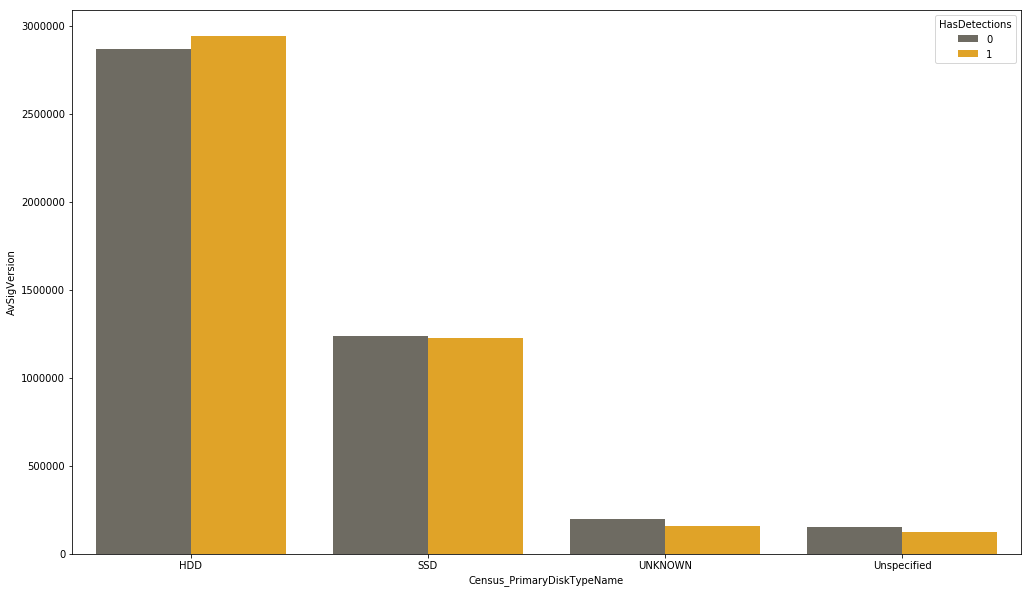

In [21]:
cat_by_detections('Census_PrimaryDiskTypeName')

<Figure size 432x288 with 0 Axes>

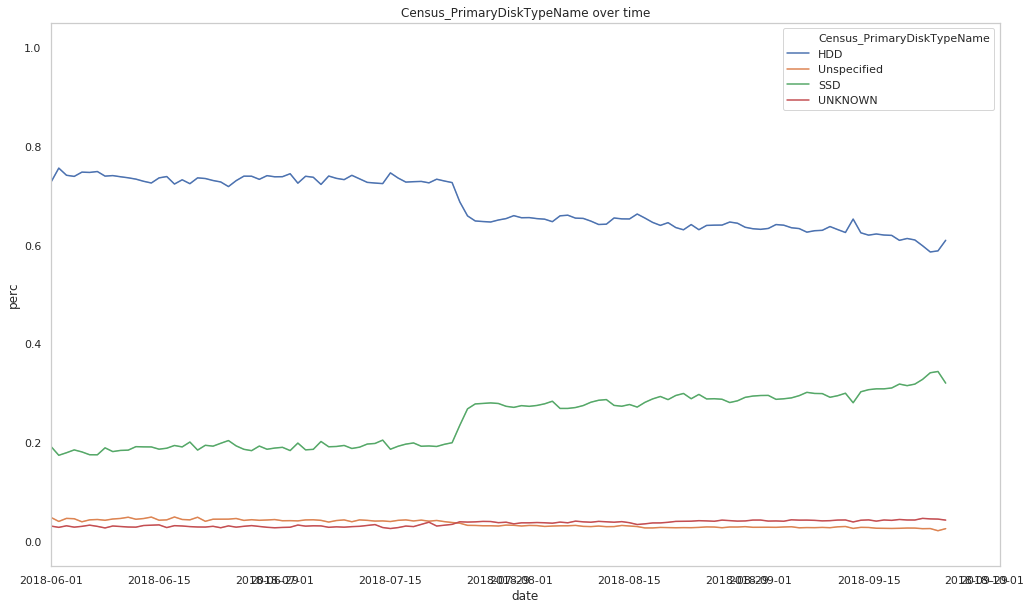

In [22]:
cat_over_time('Census_PrimaryDiskTypeName')

<Figure size 432x288 with 0 Axes>

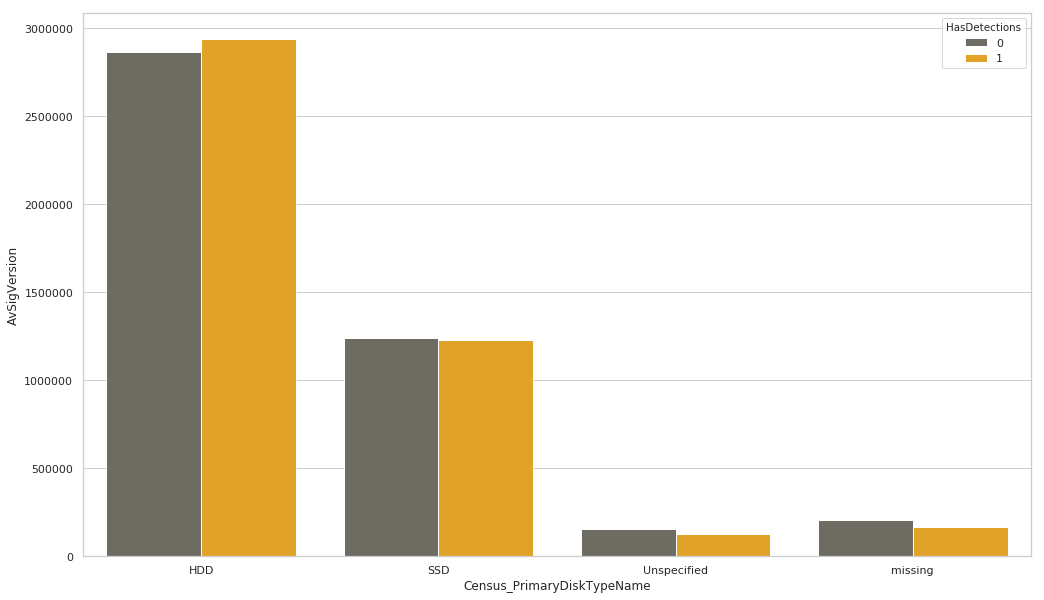

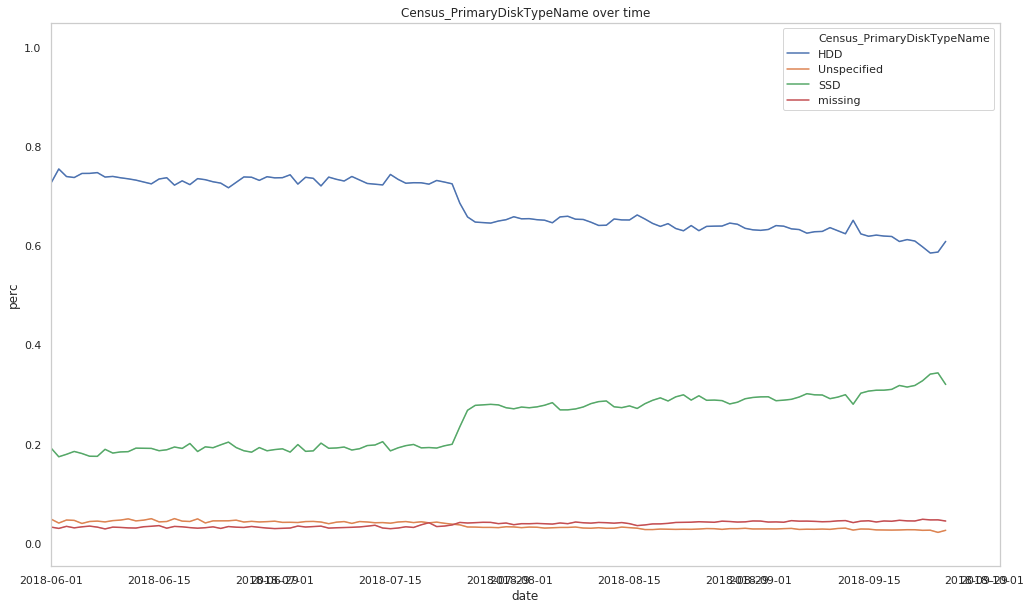

In [24]:
def transform(df):
    df.Census_PrimaryDiskTypeName = df.Census_PrimaryDiskTypeName.astype(str)
    df.loc[
        df.Census_PrimaryDiskTypeName.isnull() | 
        (df.Census_PrimaryDiskTypeName == 'nan') |
        (df.Census_PrimaryDiskTypeName == 'UNKNOWN'), 
        'Census_PrimaryDiskTypeName'] = 'missing'
    return df

train = transform(train)
test = transform(test)

cat_by_detections('Census_PrimaryDiskTypeName')
cat_over_time('Census_PrimaryDiskTypeName')

#### Census_OSWWUAutoUpdateOptionsName

<Figure size 432x288 with 0 Axes>

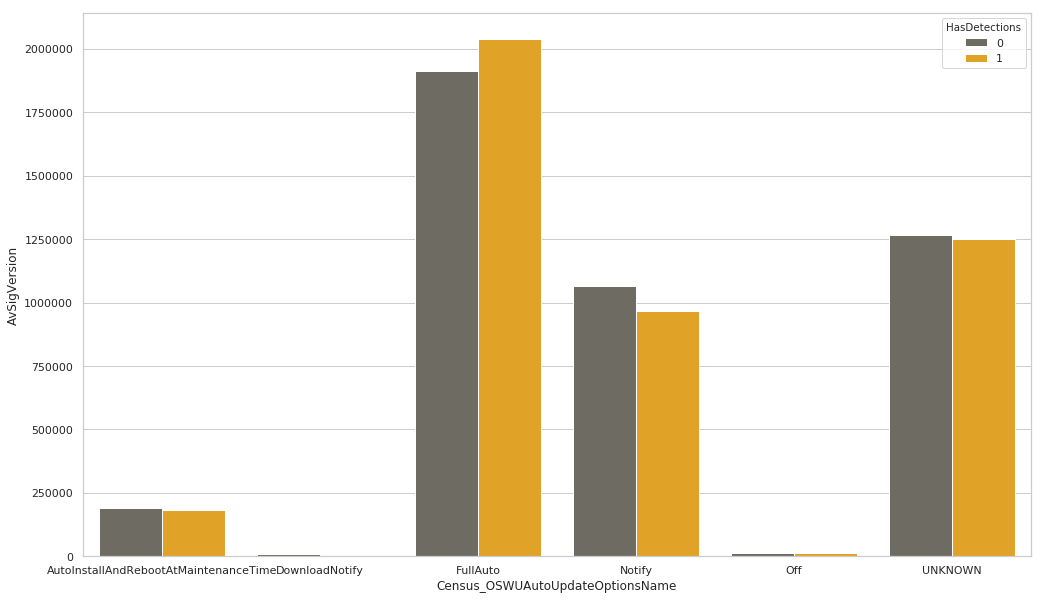

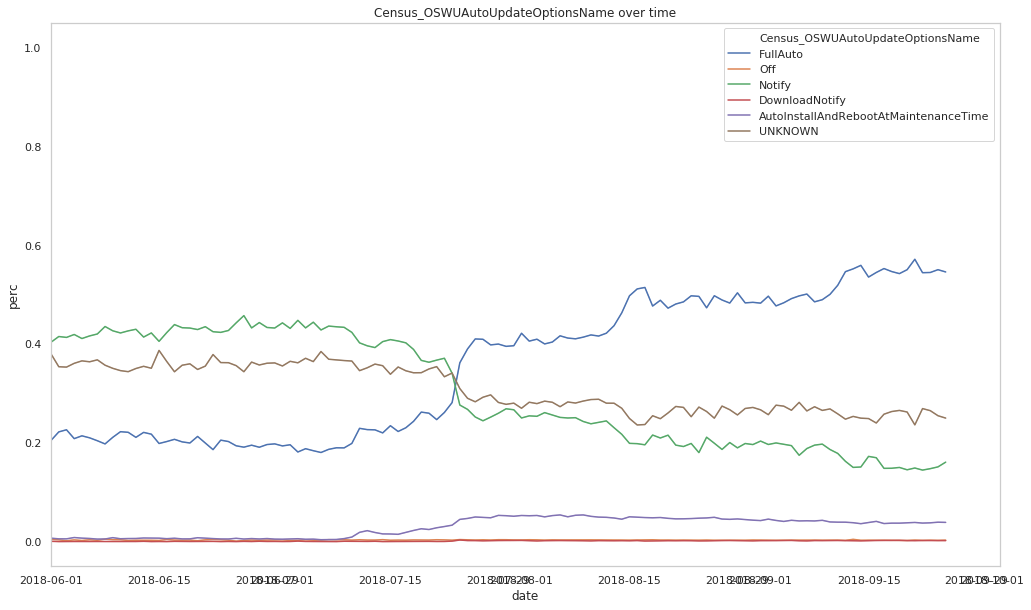

In [25]:
cat_by_detections('Census_OSWUAutoUpdateOptionsName')
cat_over_time('Census_OSWUAutoUpdateOptionsName')

In [ ]:
def transform(df):
    df.Census_OSWUAutoUpdateOptionsName = df.Census_OSWUAutoUpdateOptionsName.astype(str)
    df.loc[df.Census_OSWUAutoUpdateOptionsName == 'UNKOWN', 'Census_OSWUAutoUpdateOptionsName'] = 'Notify'
    df.Census_OSWUAutoUpdateOptionsName = df.Census_OSWUAutoUpdateOptionsName.astype('category')
    
    df.loc[
        df.Census_OSWUAutoUpdateOptionsName.isnull() |
        (df.Census_OSWUAutoUpdateOptionsName == 'UNKNOWN'),
        'Census_OSWUAutoUpdateOptionsName'
    ] = 'unknown'
    
    return df

train = transform(train)
test = transform(test)

cat_by_detections('Census_OSWUAutoUpdateOptionsName')
cat_over_time('Census_OSWUAutoUpdateOptionsName')